# Reading Data

## Connect to store (using sina local file)

First let's create an empty database with you as a single user

In a real application only admin user should have write permission to the file

In [1]:
import os
import sys
import shlex
from subprocess import Popen, PIPE
import kosh

kosh_example_sql_file = "kosh_example_read.sql"

# Create a new store (erase if exists)
store = kosh.create_new_db(kosh_example_sql_file)

## Adding datasets to the store

Let's add a dataset and associate hdf5 file with it.

In [2]:
dataset = store.create()
dataset.associate("../tests/baselines/node_extracts2/node_extracts2.hdf5", mime_type="hdf5", absolute_path=False)

/g/g19/cdoutrix/miniconda3/envs/kosh/lib/python3.6/site-packages/kosh/sina/core.py:868: UserWarning: 
In the next version the search function will return a generator.
You might need to wrap the result in a list.
  "\nIn the next version the search function will return a generator.\n"


'884679dcdab4459ca1798299adade307'

## Querying Data

In Kosh data retrievable are called "features"

Let's see which feature are associated with this dataset:

In [3]:
features = dataset.list_features()
print(features)

['cycles', 'direction', 'elements', 'node', 'node/metrics_0', 'node/metrics_1', 'node/metrics_10', 'node/metrics_11', 'node/metrics_12', 'node/metrics_2', 'node/metrics_3', 'node/metrics_4', 'node/metrics_5', 'node/metrics_6', 'node/metrics_7', 'node/metrics_8', 'node/metrics_9', 'zone', 'zone/metrics_0', 'zone/metrics_1', 'zone/metrics_2', 'zone/metrics_3', 'zone/metrics_4']


Let's get more information on a specific features

In [4]:
info = dataset.describe_feature("node/metrics_5")
print(info)

{'size': (2, 18), 'format': 'hdf5', 'type': dtype('<f4'), 'dimensions': [{'name': 'cycles', 'first': 11, 'last': 8, 'length': 2}, {'name': 'elements', 'first': 17, 'last': 15, 'length': 18}]}


## Opening Data

We might want to simply acces the URI (to add ata to it for example).

for this we will need the *id* of the associated_uri

In [5]:
associated_id = dataset.search(mime_type="hdf5", ids_only=True)[0]
h5_file = dataset.open(associated_id)
h5_file

/g/g19/cdoutrix/miniconda3/envs/kosh/lib/python3.6/site-packages/kosh/sina/core.py:508: UserWarning: 
In the next version the search function will return a generator.
You might need to wrap the result in a list.
  "\nIn the next version the search function will return a generator.\n"


<HDF5 file "node_extracts2.hdf5" (mode r)>

## Getting Data

Let's access this feature by calling the `get_execution_graph()` function.
This returns a Kosh representation of how to get to a feature's data.
Note that is just a representation (a path) to the data, not the data itself.

In [6]:
feature = dataset.get_execution_graph("node/metrics_5")
feature

This can be shorten as:

In [7]:
feature = dataset["node/metrics_5"]
feature

This gives us a handle to this feature's data, no data has actually been read yet.

Let's retrieve the data by calling the `traverse` function. This will connect the feature's origin (uri) to the data, applying any *transformer* or *operator* to it (see other notebooks to learn about these)

In [8]:
data = feature.traverse()
print(data)

<HDF5 dataset "metrics_5": shape (2, 18), type "<f4">


Which is equivalent to:

In [9]:
data = feature()
print(data)

<HDF5 dataset "metrics_5": shape (2, 18), type "<f4">


This is equivalent of what versions 1.1 and below used to do:

In [10]:
data = dataset.get("node/metrics_5")
print(data)

<HDF5 dataset "metrics_5": shape (2, 18), type "<f4">


Note that you can also slice the feature directly

In [11]:
data = feature[:]
print(data)

<HDF5 dataset "metrics_5": shape (2, 18), type "<f4">


In [12]:
# If you know the dims you can select by value and/or indices
print(dataset.describe_feature("node/metrics_1"))
feature2 = dataset["node/metrics_1"]
data2 = feature2(cycles=slice(0,1), elements=[17, 15])
print(data2.shape)

{'size': (2, 18), 'format': 'hdf5', 'type': dtype('<f4'), 'dimensions': [{'name': 'cycles', 'first': 11, 'last': 8, 'length': 2}, {'name': 'elements', 'first': 17, 'last': 15, 'length': 18}]}
(1, 2)


## Associating Multiple Sources

Let's add an image file

In [13]:
dataset.associate("../share/icons/png/Kosh_Logo_K_blue.png", mime_type="png", absolute_path=False)
dataset.list_features()

['cycles',
 'direction',
 'elements',
 'node',
 'node/metrics_0',
 'node/metrics_1',
 'node/metrics_10',
 'node/metrics_11',
 'node/metrics_12',
 'node/metrics_2',
 'node/metrics_3',
 'node/metrics_4',
 'node/metrics_5',
 'node/metrics_6',
 'node/metrics_7',
 'node/metrics_8',
 'node/metrics_9',
 'zone',
 'zone/metrics_0',
 'zone/metrics_1',
 'zone/metrics_2',
 'zone/metrics_3',
 'zone/metrics_4',
 'image']

(403, 431, 4)


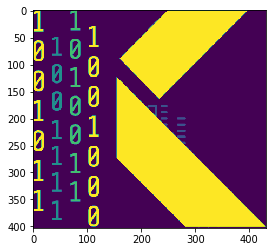

In [14]:
img = dataset["image"]
print(img[:].shape)
try:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.imshow(img[...,-1])  # Plot last channel
except ImportError:
    print("You will need matplotlib to plot the picture")

We can also retrieve the png as the raw binary data

In [15]:
raw = img(format="bytes")
len(raw), type(raw)

(694772, bytes)

We can associate many image files but this leads to duplicate "image" feature

In [16]:
# let's remove hdf5 for clarity
dataset.dissociate("../tests/baselines/node_extracts2/node_extracts2.hdf5", absolute_path=False)
dataset.list_features()

['image']

Now let's associate a second image file

In [17]:
dataset.associate("../share/icons/png/Kosh_Logo_K_orange.png", mime_type="png", absolute_path=False)
dataset.list_features()  # URI is now added to feature to disambiguate them

['image_@_../share/icons/png/Kosh_Logo_K_blue.png',
 'image_@_../share/icons/png/Kosh_Logo_K_orange.png']

In [18]:
dataset.describe_feature("image_@_../share/icons/png/Kosh_Logo_K_orange.png")

{'size': (427, 403), 'mode': 'RGBA', 'format': 'PNG'}

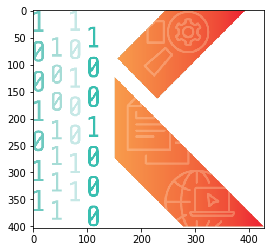

In [19]:
try:
    plt.imshow(dataset.get("image_@_../share/icons/png/Kosh_Logo_K_orange.png"))  # Plot last channel
except Exception:
    print("With matplotlib you would have seen a ")